# Satelite Fraction Mock

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL2) and put galaxies in it in a way that creates a universe consistent with HSC observations (the SMF and clustering). We then can look at the satellite fraction in that model (something we can't observe).

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

We use this functional for to generate models using a couple of halo properties. We expect that Mvir is a bad halo property (because satellites are stripped) but don't have strong prior info about whether Vmax@Mpeak is better than Mpeak. See [appendix A](./appendix.ipynb) to see how we find reasonable starting parameters for the Vmax model.

With these initial fits we run an optimizer that takes into account both the SMF and the clustering. For both Mpeak and Vmax@Mpeak we can fit to HSC. We then run an MCMC to compute the expected value and variance of the satellite fractions.


### How to run this

You always need to run section 1 (imports) and 2 (load the data + initial config). Check the top of section 2 for some options. Then:

* Run section 3 if you want to find bestfit parameters. Takes O(1 hour)
* Don't run section 4. It doesn't work well, though a decent example of a GP powered MCMC. Takes O(6 hours) to compute the training data, O(10 mins) to run an MCMC.
* Run section 5 if you want to build a model universe. See [the analysis notebook](./analysis.ipynb) for some analysis on these bestfit mocks. Takes O(1 minute)
* Run section 6 if you want to constrain the satellite fraction with an MCMC. Takes O(1 hour).

## Import etc...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize

import data as d
import likelihood as l
import plots as p
import clustering as c
import sat_fraction
import lhs_setup
import photoz

import emcee
import corner
from pyDOE import lhs

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf
import GPy
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, Queue, Manager
from scipy.stats.distributions import trapz, norm
from scipy.stats import multivariate_normal

import statsmodels.stats.weightstats
%run ~/.jupyter/config.ipy # If you are not me, you might need to comment this out. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data + initial config

In [ ]:
# Dividing mass around which to do clustering
cen_sat_div = [11.65, 11.75, 11.85]

# What halo parameter to build the model on
use = "mhalo"

In [55]:
if use == "vmax":
    x_field = "Vmax@Mpeak"
    # Starting params
    b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
    s_params = [-0.1, 0.5]
    params = b_params + s_params
    
    # Superseeded by best fit
    best_fit = params = [2.38288312, 0.35830082, 0.18331329, -0.11089013, 0.52131932] # extra_params = {1: 10.92, 4: 0.28}
    best_fix_extra_params = extra_params = {1: 10.92, 4: 0.28}
    best_fit_w_extra_params = [2.38288312, 10.92, 0.35830082, 0.18331329, 0.28, -0.11089013, 0.52131932]
elif use == "mpeak":
    x_field = "Mpeak"
    # Starting params
    b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
    s_params = [-0.06, 1.08]
    params = b_params + s_params
    
    # Superseeded by best fit
    best_fit = best_fit_w_extra_params = params = [12.97558416, 11.11936096, 0.61607271, 0.36313096, 1.90456701, -0.06276395, 1.0539316]
    extra_params = None
elif use == "mhalo":
    x_field = "Mvir"
    # Used same starting params as Mpeak
    best_fit = best_fit_w_extra_params = params = [12.90153217, 11.11207968,  0.62098038,  0.36559776,  1.89475236, -0.06317781,  1.04911798] # 24.962536143908814
    extra_params = None
    
print(f"Using {x_field}")

Using Mvir


In [4]:
# The simulation data
sim_data, sim_size = d.load_mdpl()
print(np.log10(np.min(sim_data["Mpeak"])))

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

11.169422622696432
[Memory]26.2s, 0.4min   : Loading compute_hsc_clustering...
[Memory]26.2s, 0.4min   : Loading compute_hsc_clustering...
[Memory]26.2s, 0.4min   : Loading compute_hsc_clustering...


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/joblib/hashing.py:212: FutureWarning:Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Constraints down to mass: 11.45034569426801


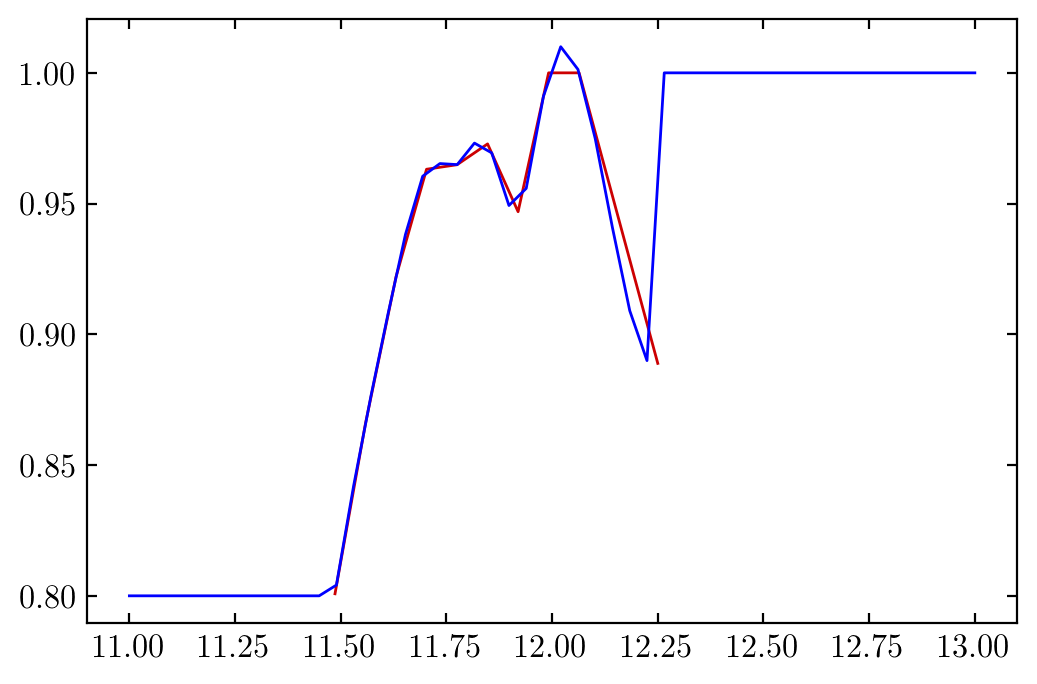

In [5]:
# A function that computes the fraction of spec-z at a given stellar mass
frac_photoz_f = photoz.get_fraction(plot=True)

test = np.linspace(11, 13)
plt.plot(test, frac_photoz_f(test))

# Find bestfit to SMF with optimizer

In [7]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, frac_photoz_f, cen_sat_div, x_field, 3, extra_params),
    method="Nelder-Mead",
)
assert res.success == True
best_fit = res.x

[12.97558416 11.11936096  0.61607271  0.36313096  1.90456701 -0.06276395  1.0539316 ] 26.052355740367318
[13.62436337 11.11936096  0.61607271  0.36313096  1.90456701 -0.06276395  1.0539316 ] 396.7016251322031
[12.97558416 11.67532901  0.61607271  0.36313096  1.90456701 -0.06276395  1.0539316 ] 481478.10952965415
[12.97558416 11.11936096  0.64687635  0.36313096  1.90456701 -0.06276395  1.0539316 ] 32.94560907252526
[12.97558416 11.11936096  0.61607271  0.38128751  1.90456701 -0.06276395  1.0539316 ] 31.522251685256528
[12.97558416 11.11936096  0.61607271  0.36313096  1.99979536 -0.06276395  1.0539316 ] 32.580094491643415
[12.97558416 11.11936096  0.61607271  0.36313096  1.90456701 -0.06590215  1.0539316 ] 88.96434692610126
[12.97558416 11.11936096  0.61607271  0.36313096  1.90456701 -0.06276395  1.10662818] 318.3791287936538
[13.16094965 10.56339291  0.62487375  0.36831855  1.93177511 -0.06366058  1.06898777] 604.0084811526148
[13.11460828 10.84137694  0.62267349  0.36702165  1.92497309

[12.89884429 11.1108969   0.62266821  0.36400738  1.90094699 -0.06326539  1.04851574] 32.30806689712666
[12.89557563 11.11038896  0.62037235  0.36508488  1.89495913 -0.06324774  1.04847656] 29.532627964553978
[12.88135003 11.10948157  0.62141804  0.36609103  1.89692617 -0.06337328  1.04805489] 28.583008449441827
[12.89171951 11.11013872  0.61924682  0.36378954  1.90345815 -0.06328338  1.04800731] 29.445876475745916
[12.89721606 11.11028383  0.62234676  0.36593253  1.88980675 -0.06319662  1.04787171] 28.572852162298673
[12.89162675 11.1100514   0.62150704  0.36489368  1.89859782 -0.06326035  1.04826305] 29.174572977177252
[12.88731962 11.11014537  0.62156281  0.36312219  1.89875972 -0.06332566  1.04843786] 27.032230974227108
[12.9080422  11.1126095   0.62258656  0.36467491  1.89894791 -0.0631768   1.04931524] 25.511304993281062
[12.89265475 11.11097963  0.62238434  0.36465844  1.8996834  -0.0632648   1.04840002] 32.20665810852462
[12.89484541 11.11053663  0.62087535  0.36497827  1.89614

[12.90138303 11.11204463  0.6210077   0.36558913  1.89475337 -0.06317956  1.04910843] 26.945418117550066
[12.90145535 11.11206857  0.62097707  0.36555087  1.89498966 -0.06317955  1.04911966] 26.805218571483678
[12.90131732 11.11203372  0.6209313   0.36554979  1.89496223 -0.06318058  1.04909288] 28.944337018462317
[12.90155389 11.11207921  0.62101918  0.36560104  1.89479901 -0.06317834  1.04912185] 30.548772538936102
[12.90149376 11.11207412  0.62097873  0.36557432  1.89487101 -0.06317868  1.04911882] 29.77251712418092
[12.9014576  11.11206216  0.62099404  0.36559345  1.89475286 -0.06317868  1.04911321] 30.433732451069712
[12.90163388 11.11208796  0.62100548  0.36558334  1.89481791 -0.0631778   1.04912106] 27.990137768530577
[12.90154315 11.11207462  0.62097936  0.36559326  1.89480252 -0.0631781   1.04911449] 28.846810617086987
[12.90150643 11.11207546  0.6209751   0.36559265  1.89483355 -0.06317862  1.04911717] 29.73740124815907
[12.90135819 11.11204903  0.62098287  0.36560123  1.89479

[12.90153448 11.11207999  0.62098074  0.36559774  1.89475194 -0.06317779  1.0491181 ] 29.127406258304287
[12.90153366 11.11207993  0.62098038  0.36559745  1.89475357 -0.06317781  1.04911813] 28.656870631465868
[12.90153176 11.11207964  0.62098031  0.36559757  1.89475296 -0.06317782  1.04911798] 26.303352893235864
[12.90153269 11.11207967  0.62098055  0.36559741  1.8947536  -0.06317782  1.04911795] 28.400790275166074
[12.90153195 11.11207967  0.62098051  0.36559764  1.89475291 -0.06317781  1.04911801] 30.434753213788397
[12.90153389 11.11207995  0.62098076  0.36559759  1.89475308 -0.06317781  1.04911815] 28.304181986387608
[12.90153408 11.11207991  0.62098052  0.36559751  1.89475298 -0.0631778   1.04911807] 30.07578382949934
[12.90153355 11.11207985  0.62098052  0.36559755  1.89475296 -0.06317781  1.04911806] 28.787413943278942
[12.90153129 11.11207955  0.62098022  0.36559736  1.89475424 -0.06317783  1.04911797] 27.389688058619
[12.90153157 11.11207961  0.62098036  0.3655975   1.8947535

[12.90153218 11.11207968  0.62098038  0.36559775  1.89475238 -0.06317781  1.04911798] 29.248939989823814
[12.9015322  11.11207968  0.62098038  0.36559775  1.89475239 -0.06317781  1.04911798] 29.85122705195932
[12.90153218 11.11207968  0.62098038  0.36559775  1.89475238 -0.06317781  1.04911798] 33.02565750976009
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 27.710459445152143
[12.9015322  11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 27.577664076142913
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 29.870614031979223
[12.90153219 11.11207968  0.62098039  0.36559776  1.89475237 -0.06317781  1.04911798] 28.86816736294449
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237 -0.06317781  1.04911798] 30.086508436889247
[12.90153216 11.11207968  0.62098038  0.36559775  1.89475239 -0.06317781  1.04911798] 28.1287637162137
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475237

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.930522632789582
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.444571444952995
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.94913596984238
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.092420257877826
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.979422476469416
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.805813769781516
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.26705524596162
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.111439038050616
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.354620374925084
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.807664913543945
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.094313142928282
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.707602571550776
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.89042811542072
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.3131997409142
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.362735459912333
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.76594550147867
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.5738981091919
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.951701025235998
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.791222308038495
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.140361555714207
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.206784304249428
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.69752903792825
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.022379654266636
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.574012506137763
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.7709621900298
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.06586639761786
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.010435102388623
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947523

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.720597598878694
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.945333901829965
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.732587203339097
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.79183895715612
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.01356182518229
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.73990628038309
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.416492863338558
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.594011546950448
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.667019334585973
[12.90153217 11.11207968  0.62098038  0.36559776  1.894752

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.802087853795673
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.291530969989665
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.089741839860043
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.48827576085199
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.08698755534831
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.27186661676963
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.4142930699624
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.991643377035317
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.623575117001675
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.58163973611636
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.544336096306957
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.296898015791715
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 33.08887749242968
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.761756098950983
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.35770267811114
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.559037480263193
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.743952361490912
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 25.53699695821376
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947523

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.09497955199031
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.598954342677274
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.13878108955156
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.2888281309572
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.748668849361323
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.900595465568593
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.24973276329229
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.006204102641217
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.012802074761016
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.960573994699207
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.66867571618303
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.46629564824114
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.12452383875182
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.559015804551173
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.276943511226353
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.004395680104455
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.925504781565074
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.061104035660673
[12.90153217 11.11207968  0.62098038  0.36559776  1.894752

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.12651568244717
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.29590876489226
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.176567606269924
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.46700883513588
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.217426914698223
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.162821235241857
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.4042752293134
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.782299144207585
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.7051539259895
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.678058858582887
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.836011309684174
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.51166324865896
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.162726726859333
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.905294403539916
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.089360802263858
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 26.764093929246926
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.979672521965053
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.350723923731145
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.66747454666139
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.362782009037993
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.384135883544985
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.419767775147733
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.325616213348958
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.840383866498417
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.415984489015575
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.285770808607463
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.005602580692212
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.94855788446961
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.266106682214122
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.22198142711856
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.355513672120892
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.04625146184248
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.96417211633689
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 27.912147251212495
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.296630553607105
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.08407391759104
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236

[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.34719566918651
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 31.716218786717427
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.09064939612139
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 28.582587839549646
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.76118087837169
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.095007291347873
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.381894230593375
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 30.225416394585984
[12.90153217 11.11207968  0.62098038  0.36559776  1.89475236 -0.06317781  1.04911798] 29.48030961987177
[12.90153217 11.11207968  0.62098038  0.36559776  1.8947523

AssertionError: 

# MCMC

## GP training

In [299]:
ranges = np.array([
    [2.325, 2.45],
    #[10.75, 11.15],
    [0.3, 0.4],
    [0.12, 0.24],
    #[0.2, 0.4],
    [-0.15, -0.05],
    [0.25, 0.6],
])

samples = lhs(len(ranges), samples=12500)
samples = lhs_setup.bias_lhs_draws(samples, ranges)
# 6 in 15s, 25 in 1m, 1500 in 1h, 10 000 overnight!

In [ ]:
def f(params):
    np.random.seed() # Required else workers share state.
    return l.compute_chi2_n(params, sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 1, extra_params)

with Pool(6) as p:
    chi2 = p.map(f, samples)
chi2 = np.array(chi2)

# 6 in 15s, 25 in 1m, 1500 in 1h, 10 000 overnight!

In [301]:
np.savez("intermediate_data/training7", chi2=chi2, samples=samples)

## Build GP

In [303]:
inter = np.load("intermediate_data/training7.npz")
chi2 = inter["chi2"]
samples = inter["samples"]

cut = np.isfinite(chi2) & (chi2 < 200) # I'm not sure why but this seems to help a lot...
samples = samples[cut]
chi2 = chi2[cut].reshape((-1, 1))

train_chi2, test_chi2, train_samples, test_samples = train_test_split(chi2, samples, train_size=0.75)
print(len(train_chi2))

3423


In [304]:
k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * train_chi2.flatten()))
#k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * np.ones_like(train_chi2.flatten())))

k_rbf = GPy.kern.RBF(5, lengthscale=1, ARD=True)

In [312]:
m = GPy.models.GPRegression(train_samples, train_chi2, k_rbf + k_fixed)

In [313]:
##### see http://www.nathan-rice.net/gp-python/
# https://github.com/SheffieldML/GPy/issues/196

m.Gaussian_noise.constrain_fixed(0)
m.kern.fixed.variance.constrain_fixed(1)
# 0.1296617, 0.18700274, 0.23861465, 0.14460889, 0.3877259 and 31367601 bestfit for the 5 param model (excluding scatter)
# 0.13326385, 0.18159825, 0.30006619, 0.16730445, 0.43229114, 0.03384369, 0.08497144 and 31367601 bestfit for the 7 param model
#m.kern.rbf.lengthscale = np.array()
m.kern.rbf.variance = 300**2

In [321]:
m.optimize(messages=True, max_iters=5)
print(np.array(m.kern.rbf.lengthscale))

[0.06738685 0.15110338 0.09118015 0.0227844  0.05727554]


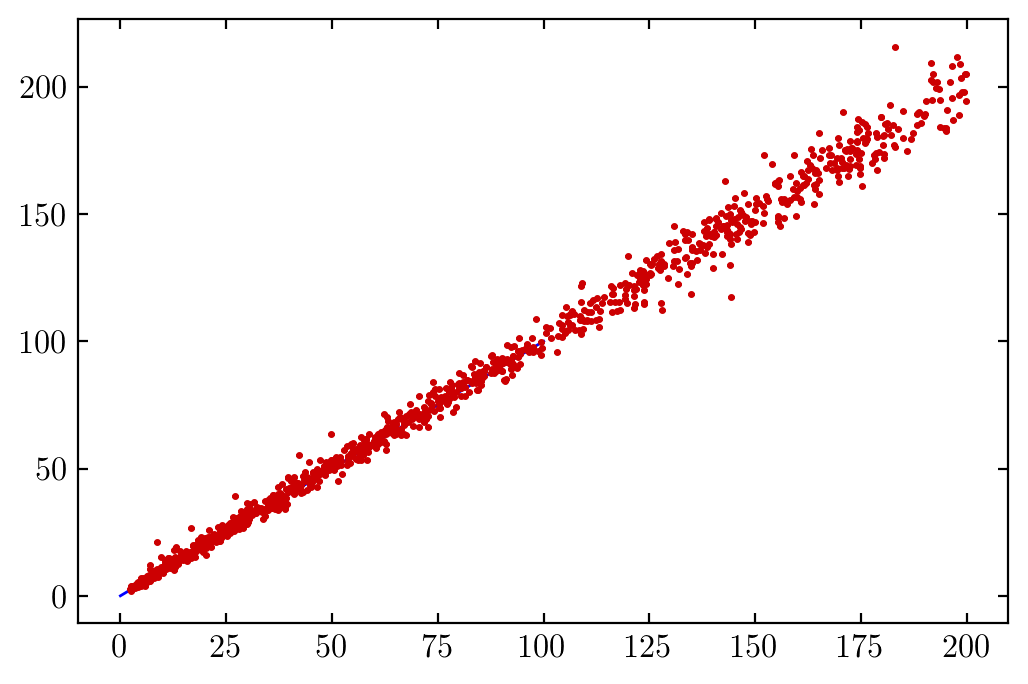

In [322]:
true = test_chi2.flatten()
pred = m.predict(test_samples, kern=m.kern.rbf)
gp = pred[0].flatten()
gp_err = pred[1].flatten()

#gp, gp_err = [-lnprob(i) for i in test_samples], 0

lim = 1e2
_, ax = plt.subplots()
ax.errorbar(true, gp+np.sqrt(gp_err), yerr=0, ls="", marker=".")
ax.plot([0, lim], [0, lim])
#ax.set(xlim=(0, lim), ylim=(0, lim))

## MCMC

In [323]:
# Return the lnprob that we have better than 1sigma confidence in
# We do this rather than the mean so that far away points are discouraged.
def lnprob(x):
    if np.all(x > ranges[:,0]) and np.all(x < ranges[:,1]):
        pred = m.predict(x.reshape((1, -1)), kern=m.kern.rbf)
        return -(pred[0][0][0] + np.sqrt(pred[1][0][0]))
    else:
        return -1e20

ndim, nwalkers = 5, 20

# Start in good positions
order = np.argsort(test_chi2.flatten())
p0 = test_samples[order][:nwalkers]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [324]:
pos, prob, state = sampler.run_mcmc(p0, 20)
sampler.reset()

In [325]:
sampler.run_mcmc(pos, 100);

In [328]:
sampler.run_mcmc(None, 1000);

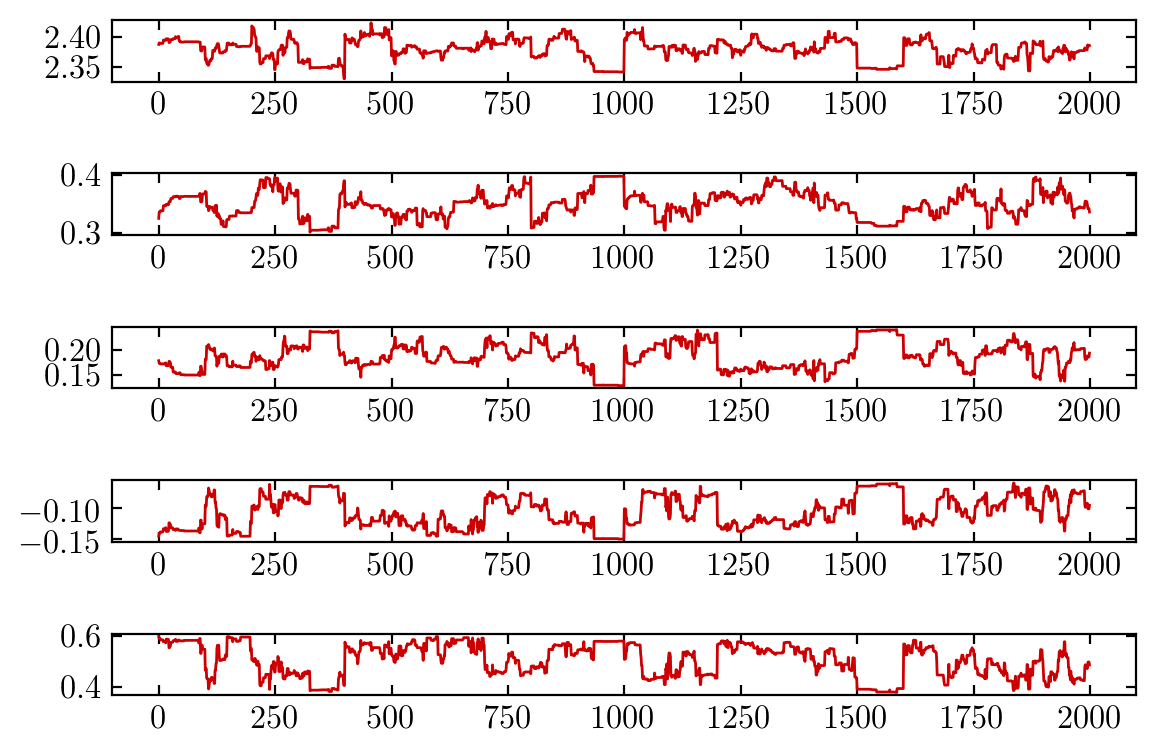

In [326]:
_, axes = plt.subplots(ndim, 1)
for i in range(ndim):
    axes[i].plot(sampler.flatchain[:,i])
plt.tight_layout()

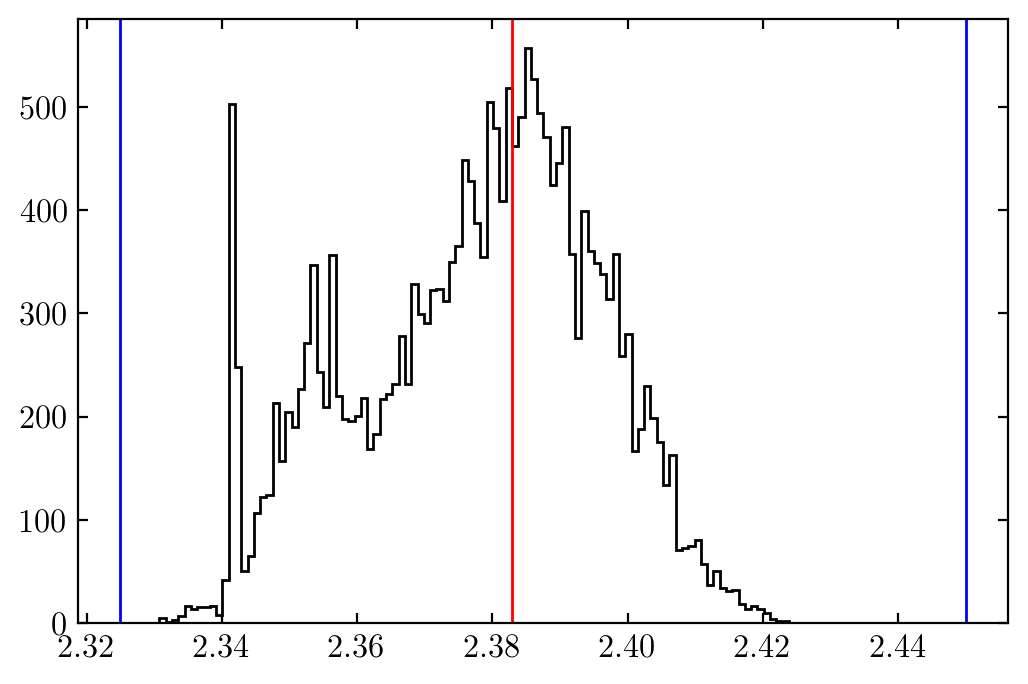

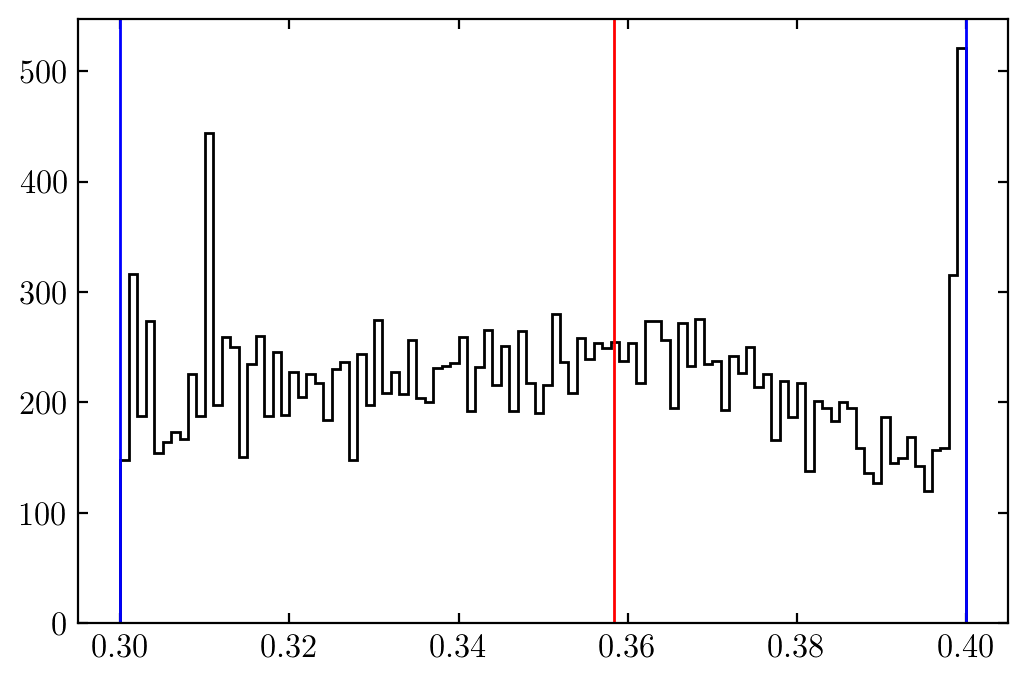

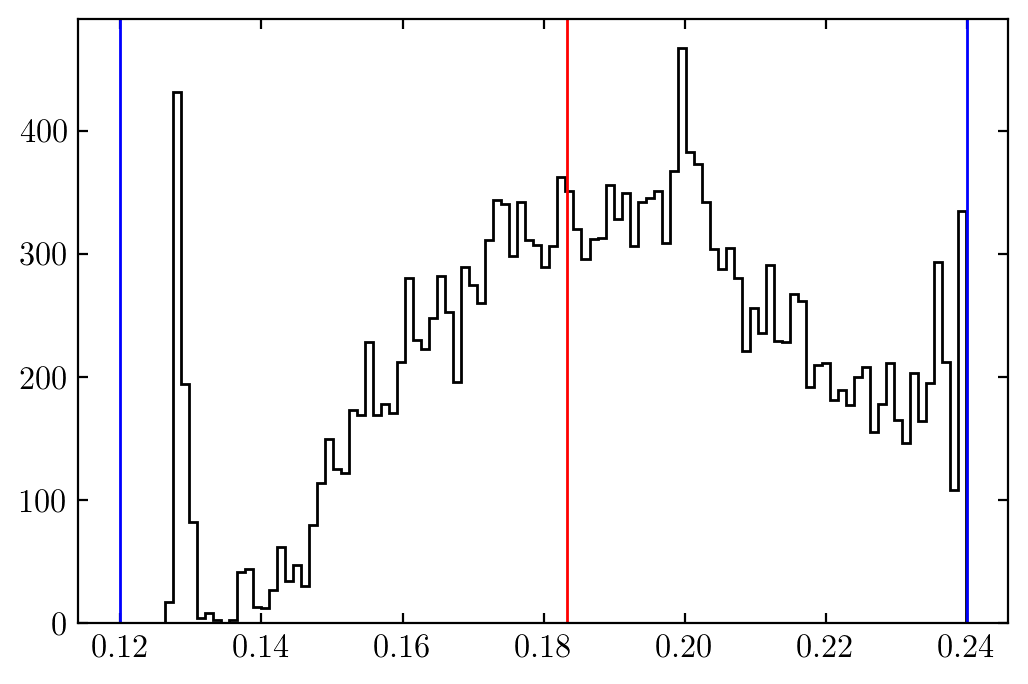

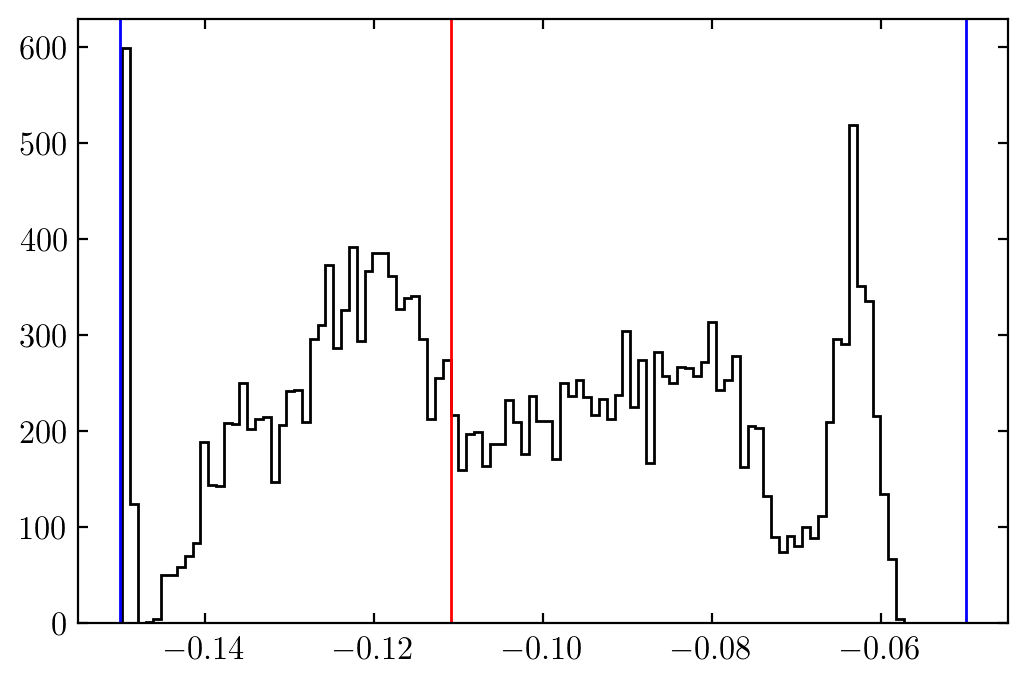

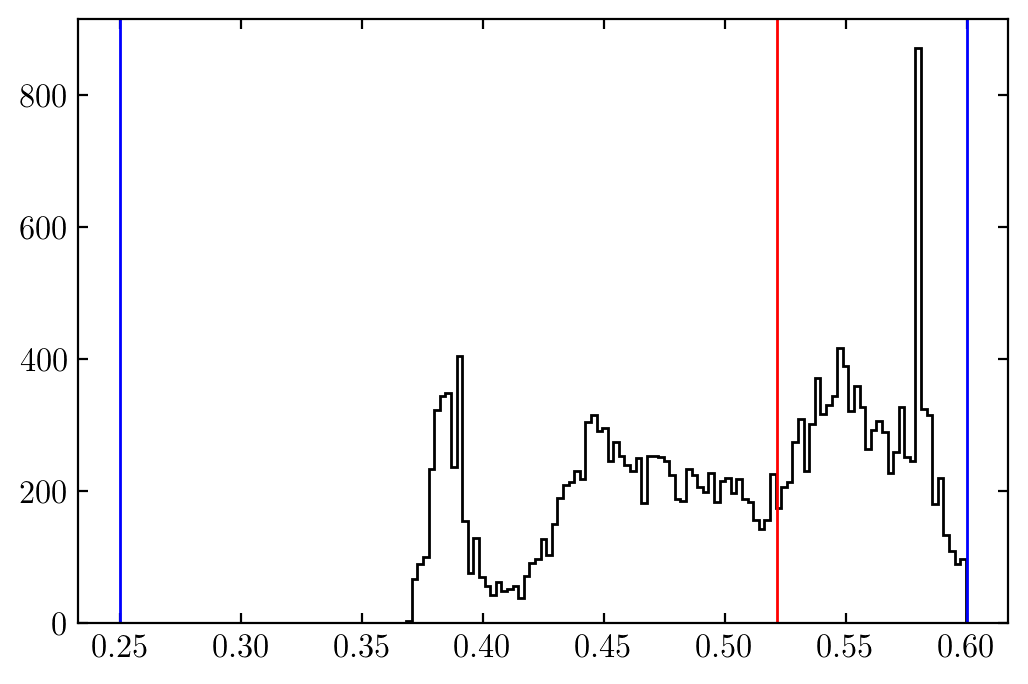

In [329]:
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    ax.axvline(best_fit[i], color="r")
    ax.axvline(ranges[i,0], color="b")
    ax.axvline(ranges[i,1], color="b")
    #ax.set(xlim=(ranges[i,0], ranges[i,1]))

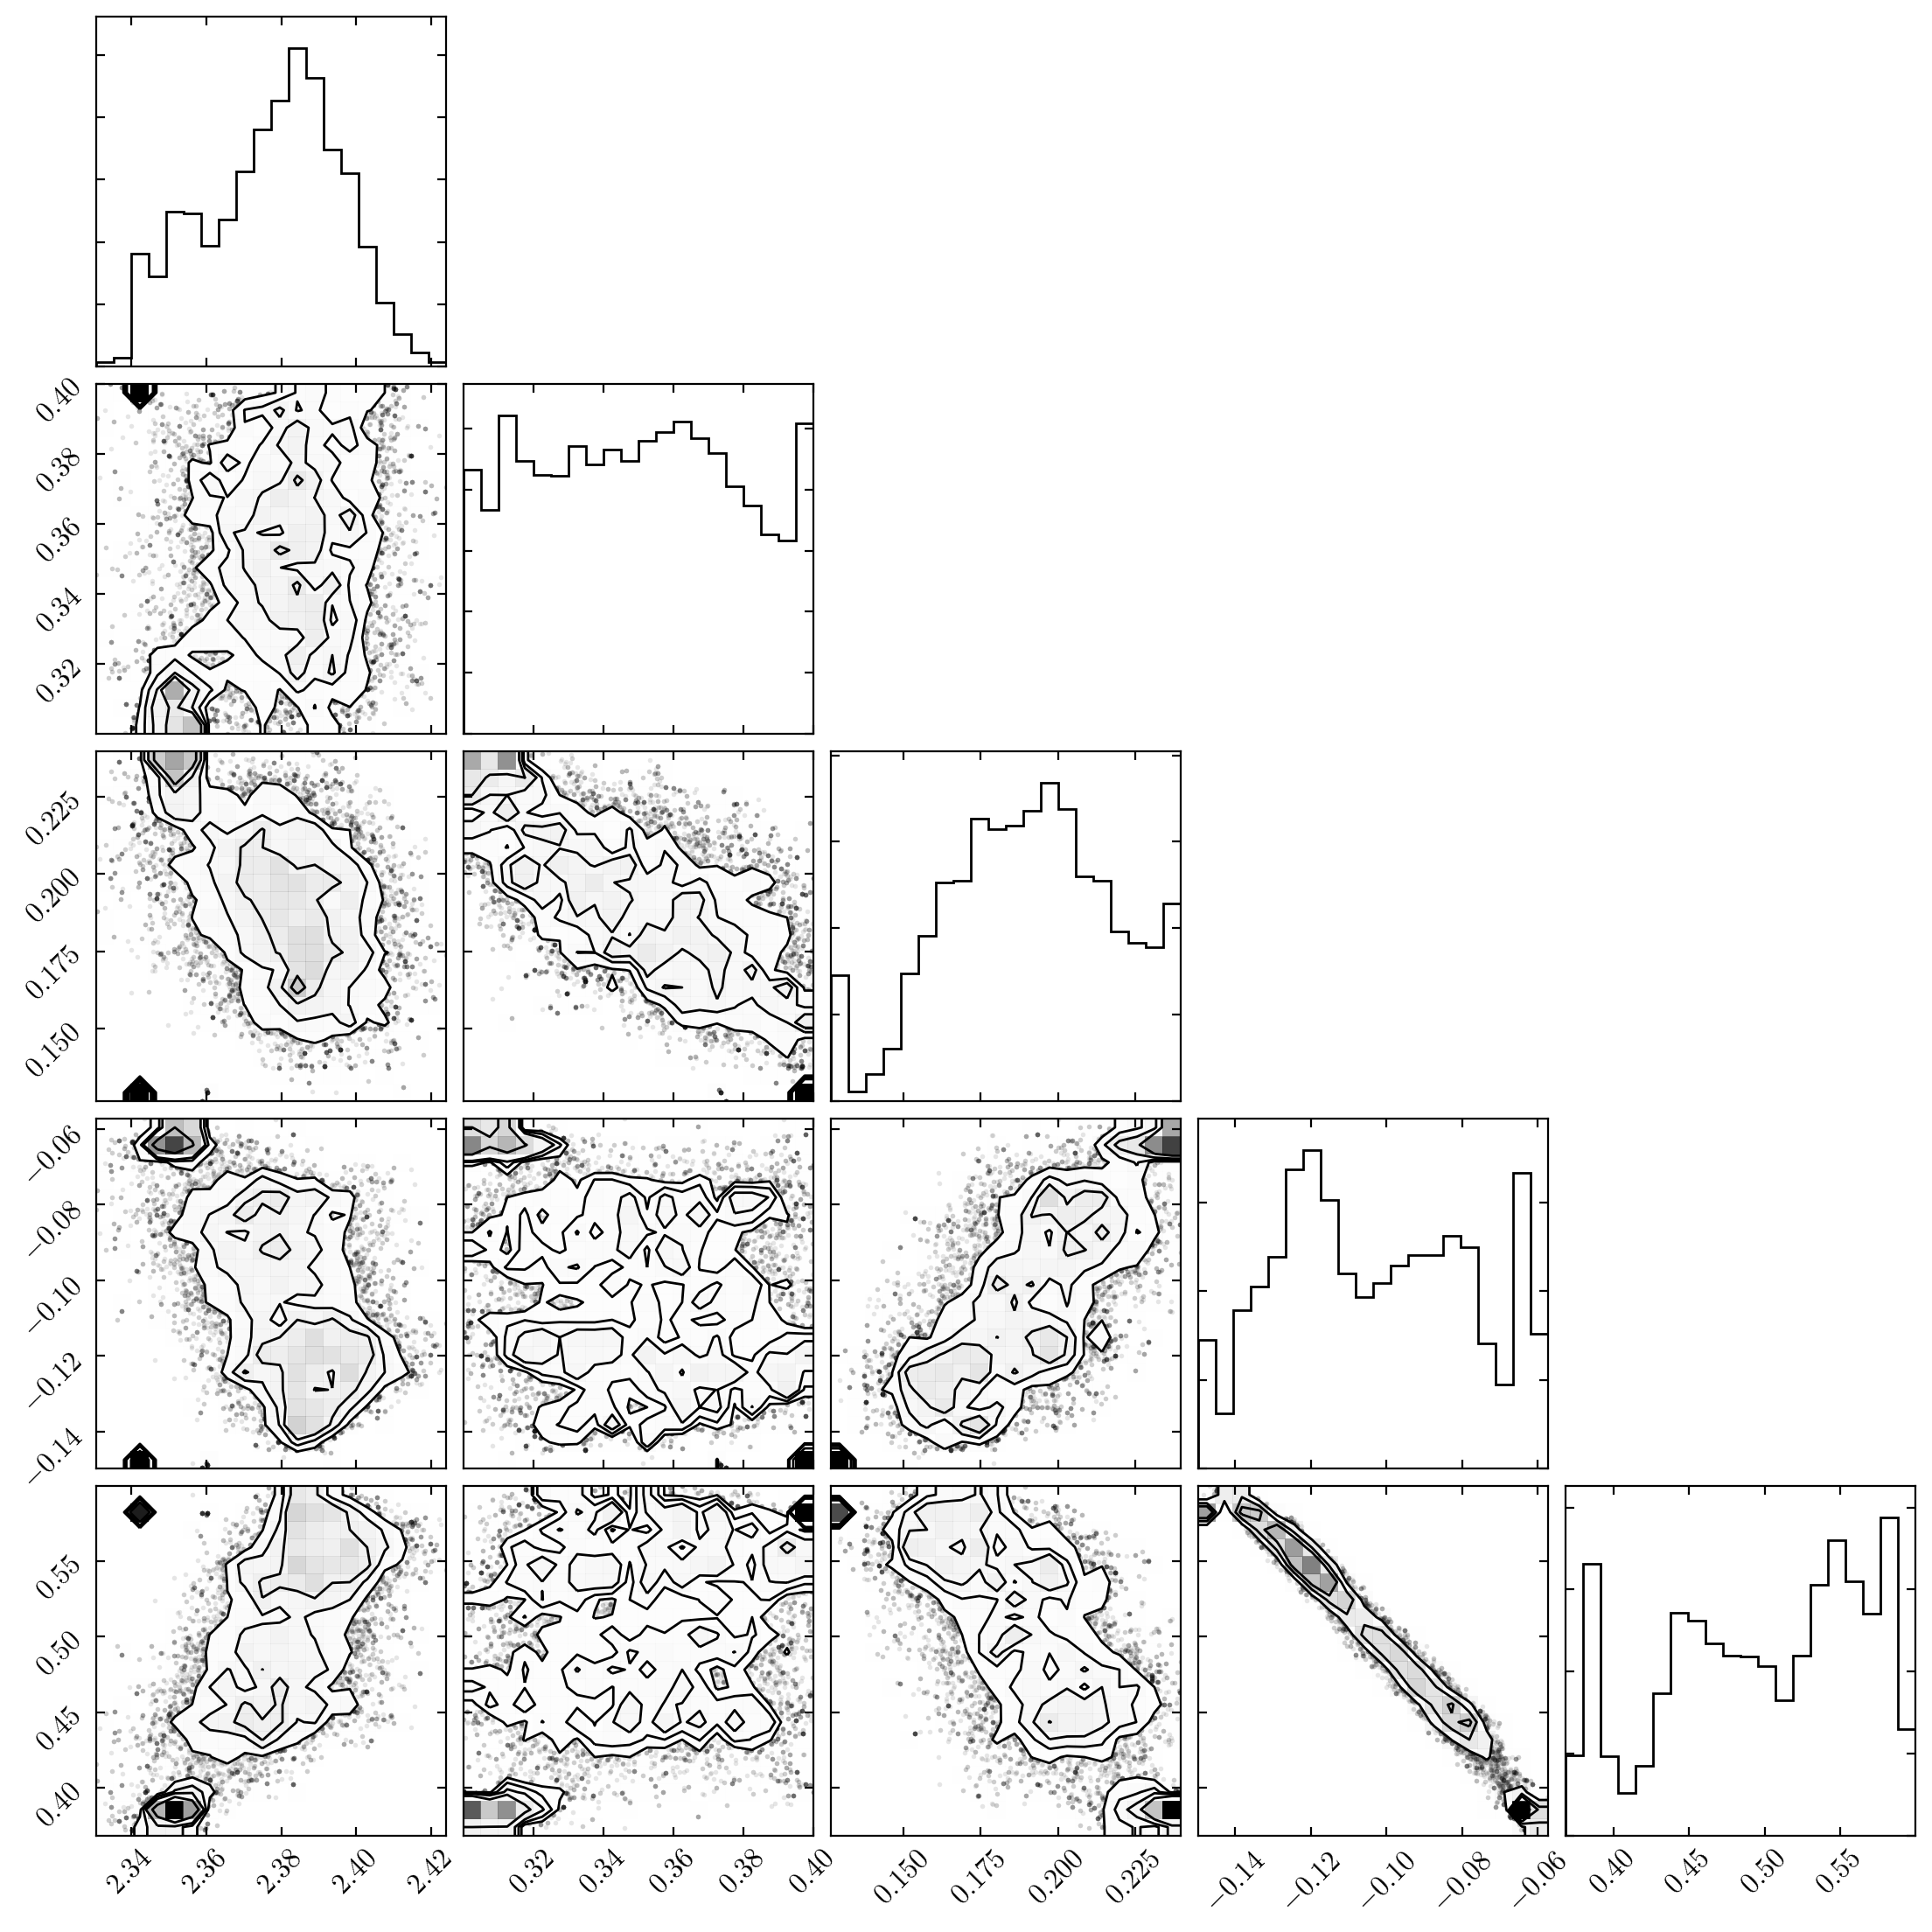

In [332]:
fig = corner.corner(sampler.flatchain)#, labels=labels, truths=[m_true, b_true, np.log(f_true)]);

In [330]:
# Sanity checks
print("Acceptance fraction should be between 0.25 and 0.5: {}".format(sampler.acceptance_fraction))
print("Total chain length: {}".format(sampler.flatchain.shape[0]))
print(sampler.get_autocorr_time(c=2))

Acceptance fraction should be between 0.25 and 0.5: [0.39090909 0.42818182 0.44727273 0.25636364 0.44       0.42909091 0.43272727 0.43181818 0.42       0.18727273 0.31636364 0.45363636 0.39909091 0.41636364 0.38909091 0.33181818 0.36909091 0.42454545 0.42181818 0.42727273]
Total chain length: 22000
[99.95724226 26.9257842  43.90304073 40.84303298 64.14873894]


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/emcee/autocorr.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/emcee/autocorr.py:105: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

# Build bestfit model and compare to observations

In [56]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit_w_extra_params[:5], best_fit_w_extra_params[5:], x_field)

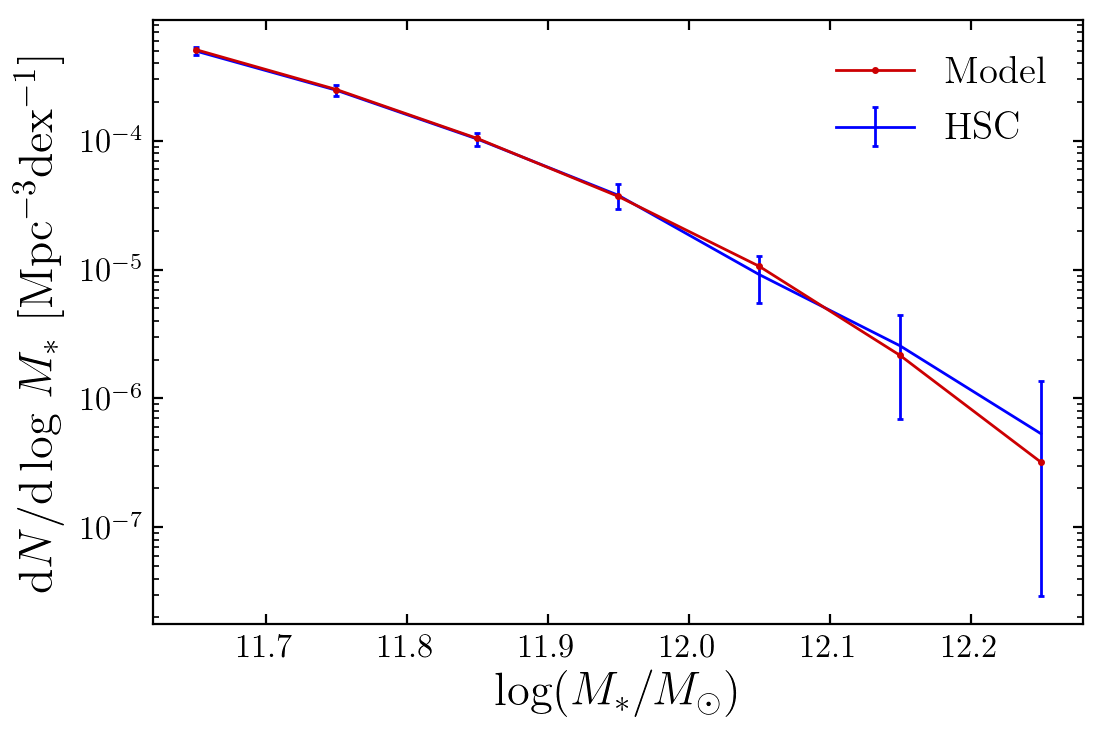

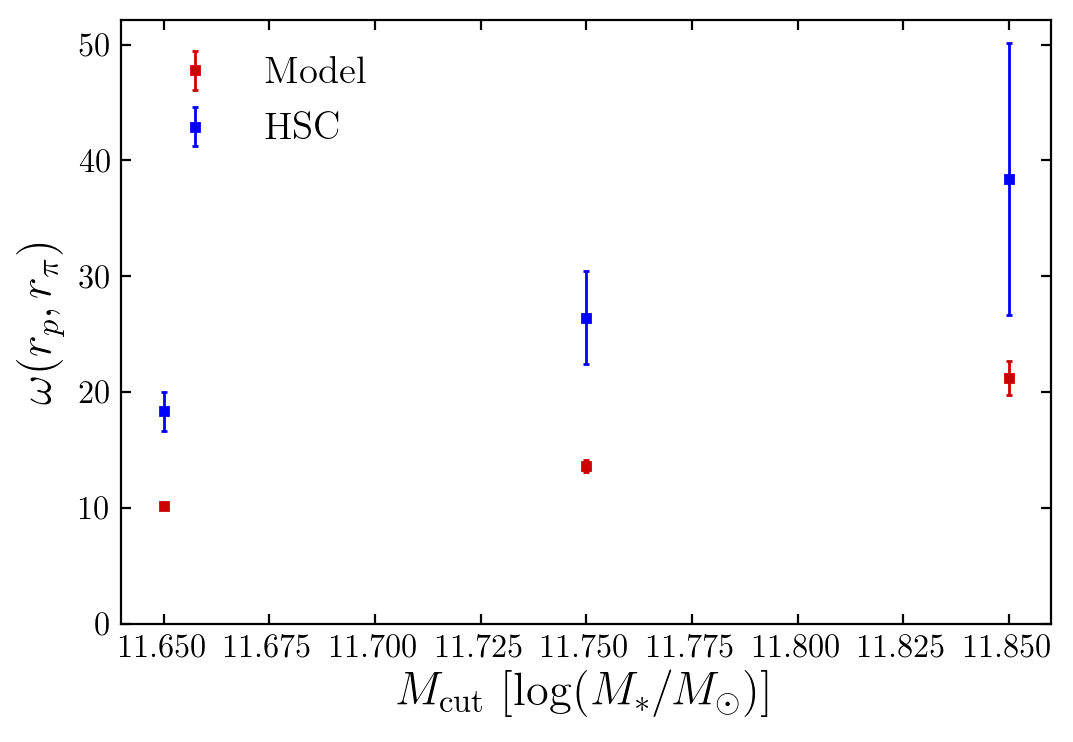

In [57]:
fig, ax = p.plot_smfs(obs_smf, log_stellar_masses, sim_size)
fig.savefig(f"/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf_{use}.png", dpi=300)


sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div, frac_photoz_f) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

fig, ax = plt.subplots()
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Model", zorder=100)
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.set(ylim=(0, ax.get_ylim()[1]))
ax.legend()

ax.set(ylabel=r"$\omega(r_p, r_{\pi})$", xlabel=r"$M_{\rm cut}\ [{\rm log}(M_{\ast} / M_{\odot})]$")
fig.savefig(f"/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust_{use}.png", dpi=300)

## Save out mock

In [13]:
sim_data_out = np.lib.recfunctions.append_fields(sim_data, names="stellar_mass", dtypes=np.float64, data=np.power(10, log_stellar_masses))
# This is commented so that you don't overwrite things by mistake!
#np.save("mocks/mhalo", np.ma.getdata(sim_data_out))

# Sat Frac MCMC

We want to compute the satellite fraction in our models. We could just do this in the bestfit model but that doesn't give us much information about the uncertainty (we can only use the Poisson error in that model). What we really want to do is see how the satellite fraction varies over all models that reasonably fit the HSC observations. 

## Setup

In [11]:
bins = np.append(
    np.linspace(11.5, 12.2, num=12),
)

def lnprob(p):
    return -l.compute_chi2(
        p,
        sim_data,
        obs_smf,
        obs_clust,
        sim_size,
        frac_photoz_f,
        cen_sat_div,
        x_field,
        extra_params=extra_params,
    )

In [12]:
ndim, nwalkers = 7, 16

# Start in reasonably good positions
p0 = best_fit + np.random.normal(size=(nwalkers, ndim)) * 0.001

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=Pool(8))

## Burn in

In [13]:
pos, prob, state = sampler.run_mcmc(p0, 50)

In [18]:
# If you need to do more burn run this
pos, prob, state = sampler.run_mcmc(None, 50);

### Check burn in

In [ ]:
_, ax = plt.subplots(figsize=(3, 2))
ax.plot(sampler.lnprobability.T)
ax.set(ylim=(-20, 0))

## Main run

In [ ]:
sampler.reset()
sampler.run_mcmc(pos, 50);

In [ ]:
# If you need to run some more, run this
sampler.run_mcmc(None, 50);

### Check chain run

(50, 16)


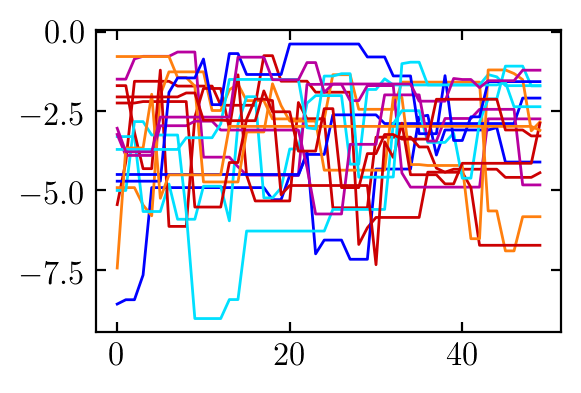

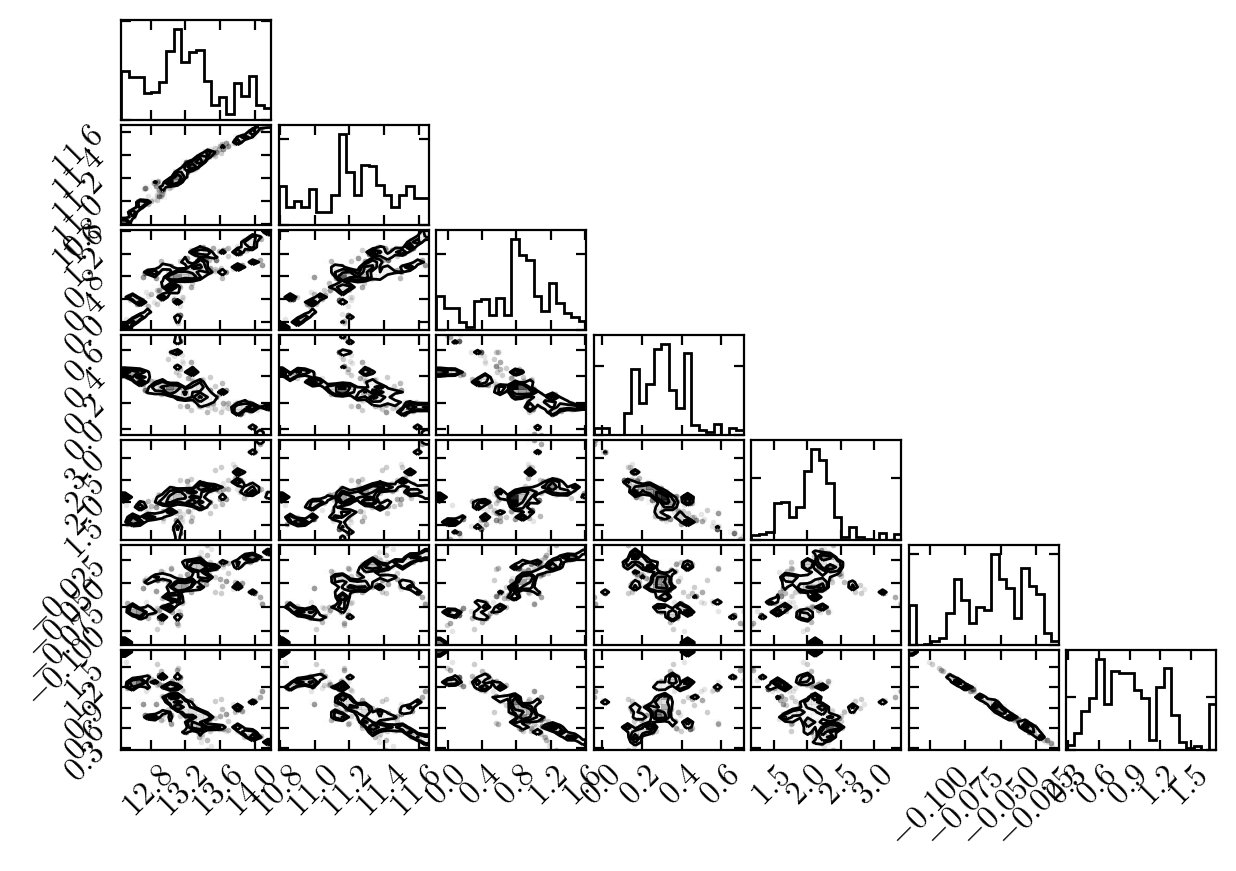

In [20]:
_, ax = plt.subplots(figsize=(3, 2))
ax.plot(sampler.lnprobability.T)
#ax.set(ylim=(-20, 0))

fig = corner.corner(sampler.flatchain)
fig.set_size_inches(6, 4)

print(sampler.lnprobability.T.shape)

## Compute the satellite fraction at each step

In [22]:
def get_sat_fracs(params):
    np.random.seed()
    full_params = l._sub_extra_params(params, extra_params)
    lsm = get_sm_for_sim(sim_data, full_params[:5], full_params[5:], x_field)
    return sat_fraction.runtime_mock(lsm, sim_data["upid"], bins)
    
    
with Pool(8) as p:
    sat_fracs = p.map(get_sat_fracs, sampler.flatchain)

In [142]:
print(np.mean(sat_fracs, axis=0))
print(np.std(sat_fracs, axis=0))

[0.17329041 0.16351137 0.1534838  0.14314963 0.1327833  0.12262855 0.11246395 0.10321713 0.09097927 0.07707946 0.06879864 0.06244895]
[0.00515429 0.00553169 0.00591232 0.00643749 0.0069296  0.00765671 0.00863657 0.00949052 0.010655   0.01501156 0.01872593 0.02779883]


In [23]:
np.savez(f"intermediate_data/{x_field}/sat_frac", sat_fraction=sat_fracs, chi2=sampler.flatlnprobability, params=l._sub_extra_params(sampler.flatchain, extra_params), bins=bins, bin_centers=(bins[1:] + bins[:-1])/2)

Check out the plot in [the analysis notebook](./analysis.ipynb)